In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 20.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 23.6 MB/s eta 0:00:00


### 0. 라이브러리

In [ ]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy
from torchsummary import summary

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from peft import get_peft_model, LoraConfig, TaskType

In [ ]:
# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

fixSEED(seed=42)

In [ ]:
# 디렉토리 설정
dir = 'Model'
path = '/content/drive/MyDrive/Projects/' + dir
os.chdir(path)
print(path)

/content/drive/MyDrive/Projects/Model


In [ ]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 데이터 불러오기 및 가공

In [ ]:
# Load data from a pickle file, and create labels
def callData(path: str):
    with open(path, "rb" ) as file:
        data = pickle.load(file)

    zero = data[data['label']==0]
    non_zero = data[data['label']==1]

    print(f'레이블 0 개수 : {len(zero)}')
    print(f'레이블 1 개수 : {len(non_zero)}')

    return data

In [ ]:
# load data
data = callData("YouTubeTotalData.pkl")

레이블 0 개수 : 4132
레이블 1 개수 : 2066


### 2. Train/Valid/Test

In [ ]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED)

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [ ]:
train_data, valid_data, test_data = splitData(data)

학습용 데이터 개수 : 3718개 
검증용 데이터 개수 : 1240개 
평가용 데이터 개수 : 1240개


### 3. Dataset 및 Dataloader 정의

In [ ]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [ ]:
# One-way BERT Dataset
class OwoWayBERTDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=64):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['content']
        label = self.data.iloc[idx]['label']

        inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)

        return input_ids, attention_mask, torch.tensor(label, dtype=torch.long) # 정수형

### 4. 모델 정의

In [ ]:
class OneWayBERTwithYouTube(nn.Module):
    def __init__(self, model_checkpoint, lora_r=8, lora_alpha=1, lora_dropout=0.1):
        super(OneWayBERTwithYouTube, self).__init__()

        # Pre-trained Model
        self.model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

        # LoRA Config
        lora_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            target_modules=["query", "value"],  # Apply LoRA to the attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # Apply LoRA to Pre-trained Layers
        self.model = get_peft_model(self.model, lora_config)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask).logits
        return outputs

### 5. 학습용 Trainer 정의

In [ ]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

    def train(self):
        train_loss_history, train_acc_history, train_f1_history = [], [], []
        valid_loss_history, valid_acc_history, valid_f1_history = [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 80)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 80)

            train_loss, train_acc, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t F1: {valid_f1:.4f}')
            print(f'(Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    torch.save(self.model.state_dict(), f'./models/RoBERTaWithYouTube_ACC_{valid_acc:.4f}.pth')
                except:
                    print('Model Not Saved')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'Early Stopping at Epoch {epoch+1}')
                    break

        return train_loss_history, train_acc_history, train_f1_history, valid_loss_history, valid_acc_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, y = batch
            input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = self.criterion(outputs, y) # 데이터셋에서 레이블을 long으로 정의함

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, y = batch
                input_ids, attention_mask, y = input_ids.to(self.device), attention_mask.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = self.criterion(outputs, y.long())

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)

### 6. 학습 진행

In [ ]:
# 데이터셋 파라미터
batch_size = 32
num_labels = 2
max_length = 128

model_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# 데이터셋 정의
train_dataset = OwoWayBERTDataset(train_data, tokenizer)
valid_dataset = OwoWayBERTDataset(valid_data, tokenizer)
test_dataset = OwoWayBERTDataset(test_data, tokenizer)

In [ ]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,  1041,  1039,  ...,  3932,  2210,     2],
         [    0,  4798,  2259,  ...,  2341, 25676,     2],
         [    0,  5621,  2043,  ...,    22,  2210,     2],
         ...,
         [    0, 20482,  2170,  ...,  2088,  1513,     2],
         [    0, 15710,  7875,  ...,  2420,  2470,     2],
         [    0,  3943,  1537,  ...,  4695,  2208,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
         1, 0, 0, 0, 0, 1, 0, 1])]

In [ ]:
# Model
model = OneWayBERTwithYouTube(model_checkpoint)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OneWayBERTwithYouTube(
  (model): PeftModelForSequenceClassification(
    (base_model): LoraModel(
      (model): RobertaForSequenceClassification(
        (roberta): RobertaModel(
          (embeddings): RobertaEmbeddings(
            (word_embeddings): Embedding(32000, 1024, padding_idx=1)
            (position_embeddings): Embedding(514, 1024, padding_idx=1)
            (token_type_embeddings): Embedding(1, 1024)
            (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): RobertaEncoder(
            (layer): ModuleList(
              (0-23): 24 x RobertaLayer(
                (attention): RobertaAttention(
                  (self): RobertaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0

In [ ]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 1838082 
All params: 338496516
--------------------------------------------------
Trainable(%): 0.54301


In [ ]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

In [ ]:
# 모델 학습 파라미터
num_epochs = 15
wait_for_es = 5

In [ ]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [ ]:
# 학습 시작
train_loss_history, train_acc_history, train_f1_history, valid_loss_history, valid_acc_history, valid_f1_history = trainer.train()

--------------------------------------------------------------------------------
Epoch 1/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.82it/s]


[Train] 	 Loss: 0.5484 	 Acc: 0.6652 	 F1: 0.0954
[Valid] 	 Loss: 0.4484 	 Acc: 0.6629 	 F1: 0.0728
(Epoch 1 complete in 1m 5s)
--------------------------------------------------------------------------------
Epoch 2/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


[Train] 	 Loss: 0.3940 	 Acc: 0.8544 	 F1: 0.6792
[Valid] 	 Loss: 0.3015 	 Acc: 0.9217 	 F1: 0.8772
(Epoch 2 complete in 2m 12s)
--------------------------------------------------------------------------------
Epoch 3/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s]


[Train] 	 Loss: 0.2770 	 Acc: 0.9515 	 F1: 0.9233
[Valid] 	 Loss: 0.2045 	 Acc: 0.9506 	 F1: 0.9264
(Epoch 3 complete in 3m 20s)
--------------------------------------------------------------------------------
Epoch 4/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


[Train] 	 Loss: 0.1898 	 Acc: 0.9704 	 F1: 0.9520
[Valid] 	 Loss: 0.1364 	 Acc: 0.9658 	 F1: 0.9512
(Epoch 4 complete in 4m 28s)
--------------------------------------------------------------------------------
Epoch 5/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


[Train] 	 Loss: 0.1333 	 Acc: 0.9733 	 F1: 0.9585
[Valid] 	 Loss: 0.1005 	 Acc: 0.9733 	 F1: 0.9607
(Epoch 5 complete in 5m 36s)
--------------------------------------------------------------------------------
Epoch 6/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.83it/s]


[Train] 	 Loss: 0.0994 	 Acc: 0.9786 	 F1: 0.9676
[Valid] 	 Loss: 0.0762 	 Acc: 0.9773 	 F1: 0.9685
(Epoch 6 complete in 6m 43s)
--------------------------------------------------------------------------------
Epoch 7/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


[Train] 	 Loss: 0.0749 	 Acc: 0.9845 	 F1: 0.9778
[Valid] 	 Loss: 0.0624 	 Acc: 0.9800 	 F1: 0.9719
(Epoch 7 complete in 7m 52s)
--------------------------------------------------------------------------------
Epoch 8/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.84it/s]


[Train] 	 Loss: 0.0620 	 Acc: 0.9861 	 F1: 0.9780
[Valid] 	 Loss: 0.0506 	 Acc: 0.9797 	 F1: 0.9704
(Epoch 8 complete in 8m 59s)
--------------------------------------------------------------------------------
Epoch 9/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.78it/s]


[Train] 	 Loss: 0.0504 	 Acc: 0.9885 	 F1: 0.9815
[Valid] 	 Loss: 0.0444 	 Acc: 0.9872 	 F1: 0.9824
(Epoch 9 complete in 10m 4s)
--------------------------------------------------------------------------------
Epoch 10/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


[Train] 	 Loss: 0.0428 	 Acc: 0.9896 	 F1: 0.9825
[Valid] 	 Loss: 0.0382 	 Acc: 0.9888 	 F1: 0.9815
(Epoch 10 complete in 11m 12s)
--------------------------------------------------------------------------------
Epoch 11/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


[Train] 	 Loss: 0.0355 	 Acc: 0.9915 	 F1: 0.9864
[Valid] 	 Loss: 0.0334 	 Acc: 0.9912 	 F1: 0.9869
(Epoch 11 complete in 12m 19s)
--------------------------------------------------------------------------------
Epoch 12/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


[Train] 	 Loss: 0.0314 	 Acc: 0.9936 	 F1: 0.9902
[Valid] 	 Loss: 0.0290 	 Acc: 0.9912 	 F1: 0.9877
(Epoch 12 complete in 13m 28s)
--------------------------------------------------------------------------------
Epoch 13/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.85it/s]


[Train] 	 Loss: 0.0266 	 Acc: 0.9920 	 F1: 0.9881
[Valid] 	 Loss: 0.0258 	 Acc: 0.9912 	 F1: 0.9855
(Epoch 13 complete in 14m 32s)
--------------------------------------------------------------------------------
Epoch 14/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.81it/s]


[Train] 	 Loss: 0.0258 	 Acc: 0.9936 	 F1: 0.9907
[Valid] 	 Loss: 0.0225 	 Acc: 0.9952 	 F1: 0.9918
(Epoch 14 complete in 15m 37s)
--------------------------------------------------------------------------------
Epoch 15/15
--------------------------------------------------------------------------------


Validating: 100%|██████████| 39/39 [00:10<00:00,  3.86it/s]

[Train] 	 Loss: 0.0221 	 Acc: 0.9935 	 F1: 0.9892
[Valid] 	 Loss: 0.0204 	 Acc: 0.9952 	 F1: 0.9933
(Epoch 15 complete in 16m 45s)


In [ ]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Plot
    plt.subplot(2, 2, 3)
    plt.plot(train_f1_history, label='Train F1 Score')
    plt.plot(valid_f1_history, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Turn off last layer
    L = plt.subplot(2, 2, 4)
    L.set_visible(False)

    plt.tight_layout()
    plt.show()

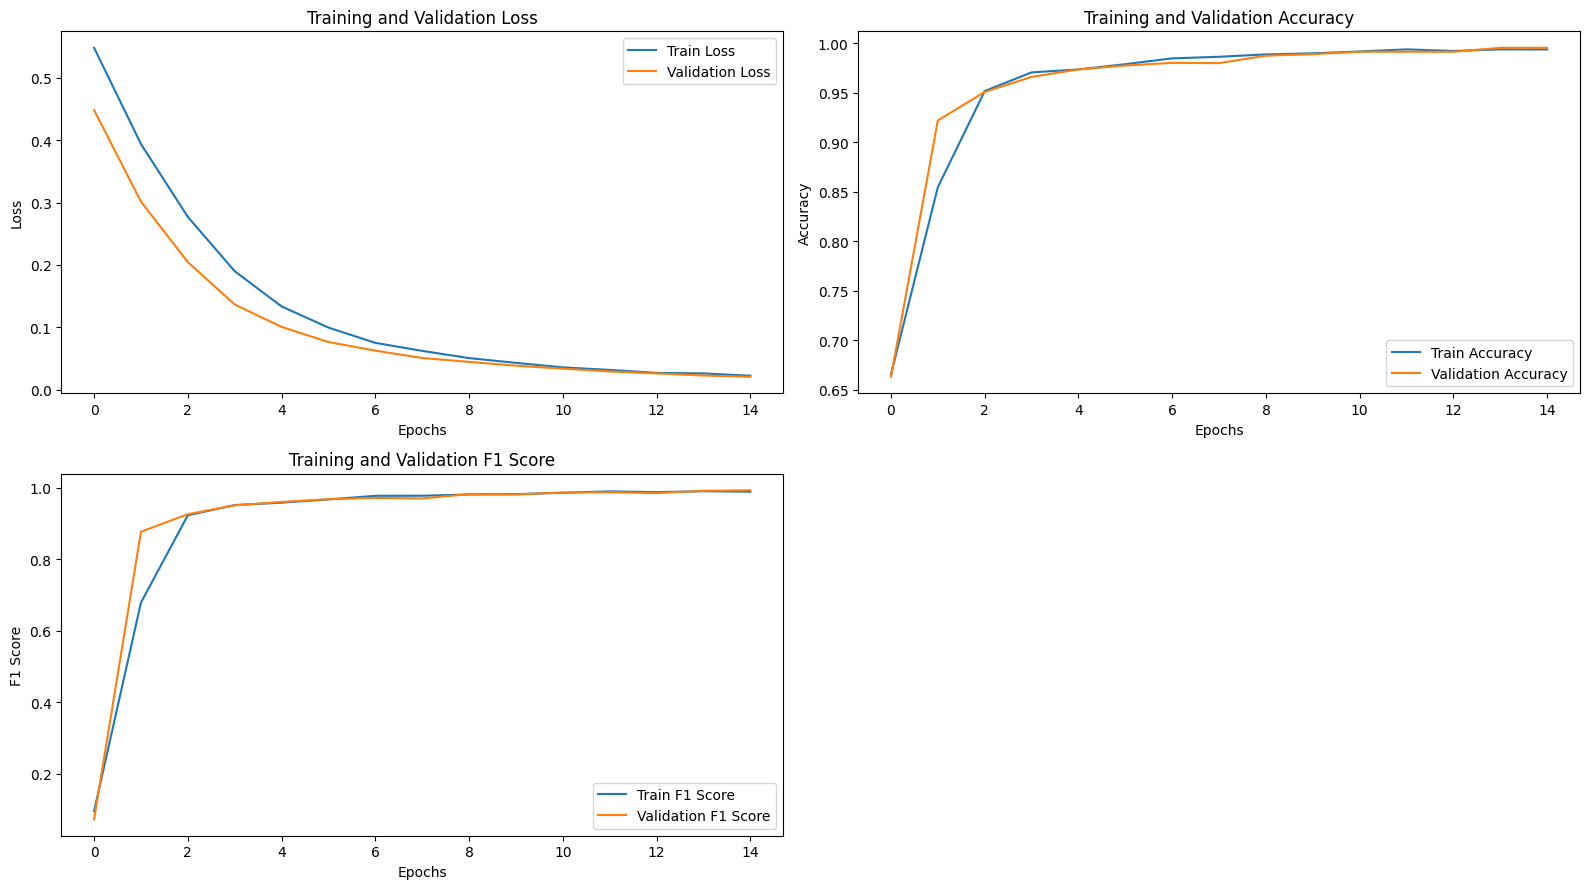

In [ ]:
plot_training_history(train_loss_history, train_acc_history, train_f1_history,
                      valid_loss_history, valid_acc_history, valid_f1_history)

In [ ]:
# 모델 로드 함수 정의
def load_model(model_path, model_checkpoint):
    model = OneWayBERTwithYouTube(model_checkpoint)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    return model

# Inference 함수 정의
def inference(model, test_dataloader, device):
    model.eval()

    preds_list = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc='Testing'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            preds_list.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return preds_list, true_labels

In [ ]:
# 저장된 모델 경로
best_model_path = path+'/models/Youtube/RoBERTaWithYouTube_ACC_0.9952.pth'

In [ ]:
# 모델 불러오기
model = load_model(best_model_path, model_checkpoint)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
preds_list, true_labels = inference(model, test_dataloader, device)

Testing: 100%|██████████| 39/39 [00:09<00:00,  3.96it/s]


In [ ]:
# 평가 지표 계산
test_accuracy = accuracy_score(true_labels, preds_list)
test_f1 = f1_score(true_labels, preds_list)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuracy: 0.9952
Test F1 Score: 0.9927
